In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import dowhy
from dowhy import CausalModel

import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler

# Sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

First we plot the ATE for random assigmnet of the treatment (10,000 samples) and for diffrent percentage of lesions


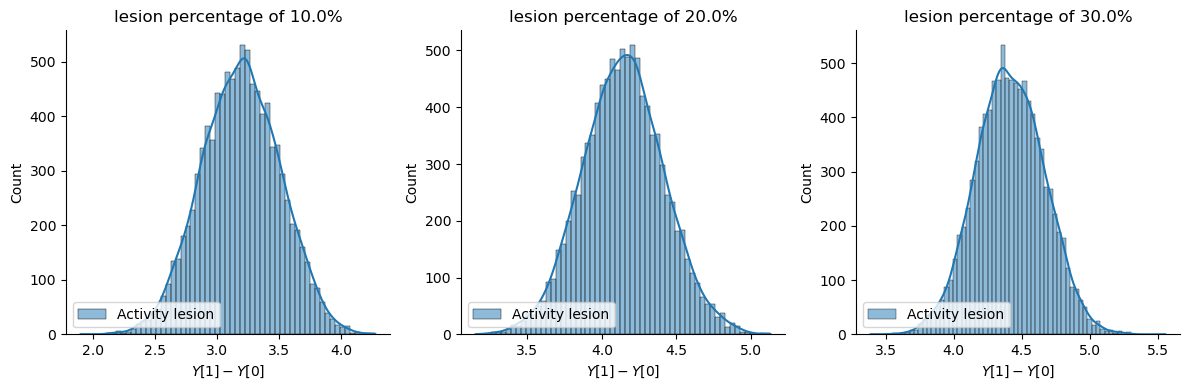

In [2]:
print('First we plot the ATE for random assigmnet of the treatment (10,000 samples) and for diffrent percentage of lesions')

fig,ax = plt.subplots(1,3,figsize=(12,4))

ate_random_treatment = [] 
for i,pr in enumerate([0.1,0.2,0.3]):

    data = pd.read_csv(f'data/results_{pr}_lesion.csv')
    
    x = [] 
    y = []
    for _ in range(10_000):
        t = np.random.randint(2,size=data.shape[0]).astype(bool)
        x.append(data[t].log_mse_lesion_activity.mean() - data[~t].log_mse_control.mean())
        
        # y.append(data[t].log_mse_lesion_connectivity.mean() - data[~t].log_mse_control.mean())

    ax[i].set_title(f'lesion percentage of {pr*100}%')
    sns.histplot(ax=ax[i],data=x, kde=True,label='Activity lesion')
    # ax[i].axvline(x=(data.log_mse_lesion_activity-data.log_mse_control).mean() ,color=sns.color_palette('tab10')[0], lw=4 )
    # sns.histplot(ax=ax[i],data=y,kde=True,label='Connectivity lesion')
    # ax[i].axvline(x=(data.log_mse_lesion_connectivity-data.log_mse_control).mean() ,color=sns.color_palette('tab10')[1], lw=4 )
    ax[i].set_xlabel(r'$Y[1] - Y[0]$')
    ax[i].legend(loc='lower left')
    
    ate_random_treatment.append(x)
    
sns.despine()
plt.tight_layout()
plt.show()



Now we plot the ATE for targeted assigmnet of the treatment (10,000 samples) and for diffrent percentage of lesions


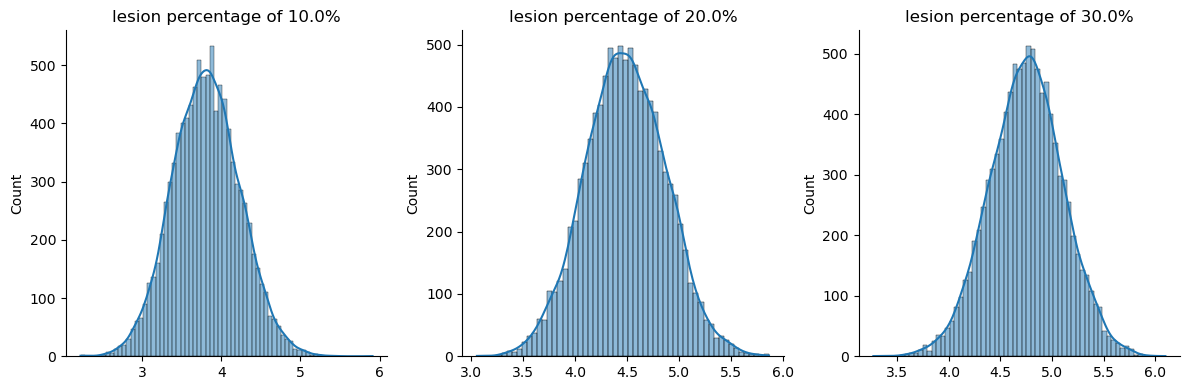

In [28]:
print('Now we plot the ATE for targeted assigmnet of the treatment (10,000 samples) and for diffrent percentage of lesions')

fig,ax = plt.subplots(1,3,figsize=(12,4))

ate_targted_treatment = []
for i,pr in enumerate([0.1,0.2,0.3]):
    df = pd.read_csv(f'data/results_{pr}_lesion.csv')
    
    df['phi'] = df['phi'].map({'tanh': 0, 'relu': 1}) # transfer phi to cat variable
    p =  -1 + -2*df['phi'] + 0.5*df['g'] + 0.005*df['hidden']
    probs_for_treatment = sigmoid(p)
    
    x = [] 
    for _ in range(10_000):
        treatment_assignment = np.array([np.random.choice(a=[0,1],p=[1-probs_for_treatment[ii],probs_for_treatment[ii]]) for ii in range(df.shape[0])])
        outcome_based_on_treatment = np.array([df.log_mse_control[ii] if treatment_assignment[ii]==0 else df.log_mse_lesion_activity[ii] for ii in range(df.shape[0])] )
        reduce_df = df[['hidden','g','phi']].copy()
        reduce_df['treatment'] = treatment_assignment.astype(int)
        reduce_df['outcome'] = outcome_based_on_treatment
        
        model = smf.ols('outcome ~ hidden + g + phi + treatment', data=reduce_df).fit()
        x.append(model.params['treatment'])
    
    ax[i].set_title(f'lesion percentage of {pr*100}%')
    sns.histplot(ax=ax[i],data=x,kde=True,label='Activity lesion')
    ate_targted_treatment.append(x)

sns.despine()
plt.tight_layout()
plt.show()
    

plot both the ATE of the random and targeted assigmnet of the treatment togther


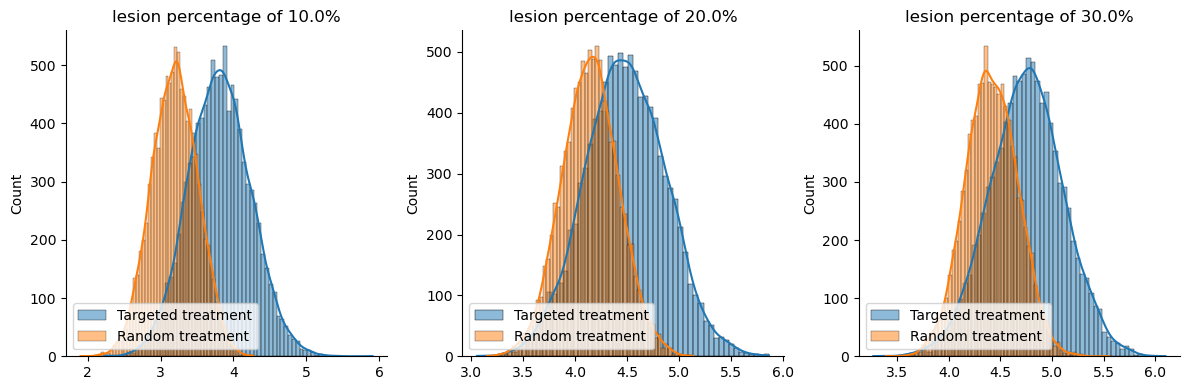

In [29]:
print('plot both the ATE of the random and targeted assigmnet of the treatment togther')

fig,ax = plt.subplots(1,3,figsize=(12,4))

for i,pr in enumerate([0.1,0.2,0.3]):
    ax[i].set_title(f'lesion percentage of {pr*100}%')
    sns.histplot(ax=ax[i],data=ate_targted_treatment[i],kde=True,label='Targeted treatment')
    sns.histplot(ax=ax[i],data=ate_random_treatment[i], kde=True,label='Random treatment')
    ax[i].legend(loc='lower left')
sns.despine()
plt.tight_layout()
plt.show()

Use dowhy library to estimate the ATE 
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                               
────────────(E[outcome|phi,hidden,g])
d[treatment]                         
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→outcome then P(outcome|treatment,phi,hidden,g,U) = P(outcome|treatment,phi,hidden,g)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': True, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'weighting_scheme': 'ips_weight'}
3.259231801094996
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'weighting_scheme': 'ips_weight

/Users/yoavger/miniconda3/envs/micra/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/yoavger/miniconda3/envs/micra/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/yoavger/miniconda3/envs/micra/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future vers

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'weighting_scheme': 'ips_weight'}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'weighting_scheme': 'ips_weight'}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'weighting_scheme': 'ips_weight'}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': [], 'weighting_scheme': 'ips_weight'}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals'

/Users/yoavger/miniconda3/envs/micra/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/yoavger/miniconda3/envs/micra/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/yoavger/miniconda3/envs/micra/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future vers

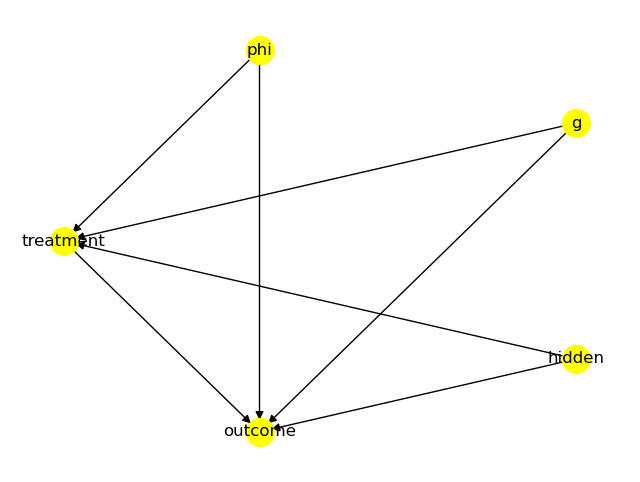

In [30]:
print('Use dowhy library to estimate the ATE ')

pr=0.1
df = pd.read_csv(f'data/results_{pr}_lesion.csv')

df['phi'] = df['phi'].map({'tanh': 0, 'relu': 1}) # transfer phi to cat variable

# normalize hidden and g variable  
# columns_to_normalize = ['hidden', 'g']
# scaler = StandardScaler()
# df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

p =  -1 + -2*df['phi'] + 0.5*df['g'] + 0.005*df['hidden']
         
# Sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

probs_for_treatment = sigmoid(p)

treatment_assignment = np.array([np.random.choice(a=[0,1],p=[1-probs_for_treatment[i],probs_for_treatment[i]]) for i in range(df.shape[0])])
outcome_based_on_treatment = np.array([df.log_mse_control[i] if treatment_assignment[i]==0 else df.log_mse_lesion_activity[i] for i in range(df.shape[0])] )
reduce_df = df[['hidden','g','phi']].copy()
reduce_df['treatment'] = treatment_assignment.astype(int)
reduce_df['outcome'] = outcome_based_on_treatment


g = """ 

digraph{
treatment;
outcome;
hidden;
g;
phi;

treatment -> outcome;

hidden -> outcome;
g -> outcome;
phi -> outcome;

hidden -> treatment;
g -> treatment;
phi -> treatment;

}

"""


model = CausalModel(
    data=reduce_df,
    treatment='treatment',
    outcome='outcome',
    graph=g
)

model.view_model()

identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

metode = 'backdoor.linear_regression' # 
deiserd_efffect = 'ate'

estimate = model.estimate_effect(identified_estimand,
                                method_name=metode,
                                target_units=deiserd_efffect,
                                 test_significance=True,
                                 method_params={"weighting_scheme": "ips_weight"}
                                )

print(estimate.value)

refute_placebo_treatment = model.refute_estimate(
    identified_estimand,  
    estimate,  
    method_name="placebo_treatment_refuter",  
    placebo_type="permute" , #  method_name="random_common_cause"
    show_progress_bar=True
)
print(refute_placebo_treatment)

In [ ]:
print("Estimating the effect of each task alone, i.e., stratification")

tasks = ['go', 'discrimination', 'flop', 'integrator']
probabilities = [0.1, 0.2, 0.3]

# Initialize dictionaries to hold results for each task
ate_random_treatment = {task: [] for task in tasks}
ate_targeted_treatment = {task: [] for task in tasks}

for task in tasks:
    print(f"\nEstimating treatment effect for task: {task}")
    
    for pr in probabilities:
        # Load and filter data for the current task
        data = pd.read_csv(f'data/results_{pr}_lesion.csv')
        data_task = data[data['task'] == task].reset_index()
        
        # Random treatment effect
        x_random = []
        for _ in range(10_000):
            t = np.random.randint(2, size=data_task.shape[0]).astype(bool)
            x_random.append(data_task[t].log_mse_lesion_activity.mean() - data_task[~t].log_mse_control.mean())
        ate_random_treatment[task].append(x_random)
        
        # Targeted treatment effect
        x_targeted = []
        data_task['phi'] = data_task['phi'].map({'tanh': 0, 'relu': 1})  # Map 'phi' to categorical
        p =  -1 + -2*data_task['phi'] + 0.5*data_task['g'] + 0.005*data_task['hidden']
        probs_for_treatment = sigmoid(p)
        
        for _ in range(10_000):
            treatment_assignment = np.array([np.random.choice(a=[0,1], p=[1 - probs_for_treatment[ii], probs_for_treatment[ii]]) for ii in range(data_task.shape[0])])
            outcome_based_on_treatment = np.array([data_task.log_mse_control[ii] if treatment_assignment[ii] == 0 else data_task.log_mse_lesion_activity[ii] for ii in range(data_task.shape[0])])
            
            reduce_df = data_task[['hidden', 'g', 'phi']].copy()
            reduce_df['treatment'] = treatment_assignment.astype(int)
            reduce_df['outcome'] = outcome_based_on_treatment
            
            model = smf.ols('outcome ~ hidden + g + phi + treatment', data=reduce_df).fit()
            x_targeted.append(model.params['treatment'])
        
        ate_targeted_treatment[task].append(x_targeted)

# Plotting
fig, axes = plt.subplots(len(tasks), 3, figsize=(12, 4 * len(tasks)), sharey=True)

for task_idx, task in enumerate(tasks):
    for i, pr in enumerate(probabilities):
        ax = axes[task_idx, i] if len(tasks) > 1 else axes[i]
        ax.set_title(f'{task.capitalize()} - Lesion Percentage: {pr * 100}%')
        sns.histplot(ax=ax, data=ate_targeted_treatment[task][i], kde=True, label='Targeted treatment')
        sns.histplot(ax=ax, data=ate_random_treatment[task][i], kde=True, label='Random treatment')
        ax.legend(loc='lower left')

sns.despine()
plt.tight_layout()
plt.show()


Estimating the effect of each task alone, i.e., stratification

Estimating treatment effect for task: go
